## This notebook explores basic properties of the dataset and computes its surprise metrics

After the initial structured part, there is a long scratch where we performed some exploratory analysis but it's quite messy.

In [13]:
import pickle
import pandas as pd

df = pd.read_csv("tkgl-smallpedia_edgelist.csv")
df.head()

ts    head     tail relation_type
0  1900    Q648  Q163700          P166
1  1900  Q28003   Q18425         P1346
2  1900  Q44949     Q458           P17
3  1900  Q48246  Q756994          P166
4  1900  Q77203   Q61769          P185

In [15]:
print(df.info())
print(df['head'].nunique())
print(df['tail'].nunique())
print(df.tail())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550376 entries, 0 to 550375
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   ts             550376 non-null  int64 
 1   head           550376 non-null  object
 2   tail           550376 non-null  object
 3   relation_type  550376 non-null  object
dtypes: int64(1), object(3)
memory usage: 16.8+ MB
None
32070
18813
          ts     head     tail relation_type
550371  2024  Q187326  Q717062          P286
550372  2024  Q266613   Q19444         P6087
550373  2024  Q284078  Q205998           P54
550374  2024  Q297603   Q19509           P54
550375  2024  Q688230  Q120917         P1308


In [16]:
# train/test split for RAG
test_start = 2008
train_df = df[df["ts"] < test_start]
test_df  = df[df["ts"] >= test_start]
print(len(train_df), len(test_df))

468790 81586


In [17]:
# train/test split and filtering for TCompoundE
train_df_filter = df[df["ts"] < 1998].copy()

train_entities = set(pd.concat([train_df_filter["head"], train_df_filter["tail"]]).astype(str).unique())

test_df_filtered = test_df[
    (test_df["head"].astype(str).isin(train_entities)) &
    (test_df["tail"].astype(str).isin(train_entities))
].copy()

print(len(train_df_filter), len(test_df_filtered))

387757 18564


In [5]:
def compute_surprise_metrics(train_df, test_df):
    train_ents = set(pd.concat([train_df["head"], train_df["tail"]]).astype(str))
    test_ents  = set(pd.concat([test_df["head"], test_df["tail"]]).astype(str))

    # Entity-level (unique entities)
    si_ent = len(test_ents - train_ents) / max(len(test_ents), 1)

    # Fact-level unseen entity rate
    head_seen = test_df["head"].astype(str).isin(train_ents)
    tail_seen = test_df["tail"].astype(str).isin(train_ents)

    si_fact_unseen_any  = (~(head_seen & tail_seen)).mean()
    si_fact_unseen_head = (~head_seen).mean()
    si_fact_unseen_tail = (~tail_seen).mean()

    # Triple-level novelty (h,r,t)
    train_triples = set(zip(train_df["head"].astype(str),
                            train_df["relation_type"].astype(str),
                            train_df["tail"].astype(str)))
    test_triples = set(zip(test_df["head"].astype(str),
                           test_df["relation_type"].astype(str),
                           test_df["tail"].astype(str)))
    si_triple = len(test_triples - train_triples) / max(len(test_triples), 1)

    return {
        "SI_entity_unique": si_ent,
        "SI_fact_unseen_any": si_fact_unseen_any,
        "SI_fact_unseen_head": si_fact_unseen_head,
        "SI_fact_unseen_tail": si_fact_unseen_tail,
        "Novel_triple_ratio_(h,r,t)": si_triple,
    }


In [6]:
# full RAG split metrics
surprise_metrics = compute_surprise_metrics(train_df, test_df)
surprise_metrics

{'SI_entity_unique': 0.339724603793193,
 'SI_fact_unseen_any': np.float64(0.29789424656191016),
 'SI_fact_unseen_head': np.float64(0.22712230039467557),
 'SI_fact_unseen_tail': np.float64(0.11935871350476797),
 'Novel_triple_ratio_(h,r,t)': 0.7619204101081134}

In [10]:
# filtered RAG split metrics
surprise_metrics = compute_surprise_metrics(train_df, test_df_filtered)
surprise_metrics

{'SI_entity_unique': 0.0,
 'SI_fact_unseen_any': np.float64(0.0),
 'SI_fact_unseen_head': np.float64(0.0),
 'SI_fact_unseen_tail': np.float64(0.0),
 'Novel_triple_ratio_(h,r,t)': 0.5090637264062792}

In [11]:
# full TCompoundE split metrics
surprise_metrics = compute_surprise_metrics(train_df_filter, test_df)
surprise_metrics

{'SI_entity_unique': 0.6445310470252014,
 'SI_fact_unseen_any': np.float64(0.7724609614394626),
 'SI_fact_unseen_head': np.float64(0.6955359988233275),
 'SI_fact_unseen_tail': np.float64(0.2756600397126958),
 'Novel_triple_ratio_(h,r,t)': 0.9464690611547435}

In [12]:
# filtered TCompoundE split metrics
surprise_metrics = compute_surprise_metrics(train_df_filter, test_df_filtered)
surprise_metrics

{'SI_entity_unique': 0.0,
 'SI_fact_unseen_any': np.float64(0.0),
 'SI_fact_unseen_head': np.float64(0.0),
 'SI_fact_unseen_tail': np.float64(0.0),
 'Novel_triple_ratio_(h,r,t)': 0.6955709213231172}

## SCRATCH

In [1]:
import pickle
import pandas as pd

with open("tkgl-smallpedia_test_ns.pkl", "rb") as f:
    index = pickle.load(f)

/var/folders/y3/yq4_6mjd0vxdjk2jv9k082q00000gn/T/ipykernel_298/2566001985.py:5: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  index = pickle.load(f)


In [2]:
type(index)

dict

In [3]:
index.keys()

dict_keys([(np.int64(2008), np.int64(20583), np.int64(0)), (np.int64(2008), np.int64(13027), np.int64(0)), (np.int64(2008), np.int64(32317), np.int64(0)), (np.int64(2008), np.int64(19163), np.int64(113)), (np.int64(2008), np.int64(32321), np.int64(86)), (np.int64(2008), np.int64(23883), np.int64(0)), (np.int64(2008), np.int64(31864), np.int64(0)), (np.int64(2008), np.int64(40898), np.int64(0)), (np.int64(2008), np.int64(27546), np.int64(1)), (np.int64(2008), np.int64(2), np.int64(1)), (np.int64(2008), np.int64(12954), np.int64(1)), (np.int64(2008), np.int64(29481), np.int64(1)), (np.int64(2008), np.int64(29483), np.int64(1)), (np.int64(2008), np.int64(40901), np.int64(4)), (np.int64(2008), np.int64(40902), np.int64(0)), (np.int64(2008), np.int64(38831), np.int64(0)), (np.int64(2008), np.int64(19532), np.int64(0)), (np.int64(2008), np.int64(22294), np.int64(0)), (np.int64(2008), np.int64(40905), np.int64(0)), (np.int64(2008), np.int64(40906), np.int64(0)), (np.int64(2008), np.int64(4090

In [4]:
example_key = list(index.keys())[0]
index[example_key]

array([24545])

In [5]:
len(index)

103430

In [6]:
import numpy as np

sizes = [len(v) for v in index.values()]
np.mean(sizes), np.min(sizes), np.max(sizes)


(np.float64(1.5776080440877889), np.int64(1), np.int64(229))

In [7]:
times = [k[0] for k in index.keys()]
import collections
collections.Counter(times).most_common(5)

[(np.int64(2009), 11694),
 (np.int64(2008), 11533),
 (np.int64(2010), 11473),
 (np.int64(2011), 11056),
 (np.int64(2012), 10440)]

In [2]:
import pandas as pd

test_start = int(min(k[0] for k in index.keys()))
test_end   = int(max(k[0] for k in index.keys()))
test_start, test_end

(2008, 2024)

In [9]:
E_test = set()
for (t,h,r), tails in index.items():
    for tail in tails:
        E_test.add((int(h), int(r), int(tail)))

len(E_test)

60862

In [5]:
E_test

{(40090, 113, 40089),
 (42647, 69, 42648),
 (27279, 69, 40410),
 (3938, 63, 46533),
 (36079, 352, 29982),
 (16162, 369, 32389),
 (34576, 69, 9556),
 (35513, 69, 26266),
 (8847, 352, 37197),
 (35681, 69, 11655),
 (9658, 352, 42403),
 (15852, 412, 22782),
 (32906, 69, 11786),
 (43838, 0, 12105),
 (16645, 352, 43364),
 (40920, 86, 8831),
 (37, 283, 17362),
 (36117, 69, 41332),
 (32495, 283, 41986),
 (43368, 69, 42614),
 (22194, 413, 26902),
 (24762, 352, 32218),
 (26448, 350, 26447),
 (24527, 352, 42380),
 (39186, 331, 44869),
 (32135, 48, 5011),
 (38122, 48, 17282),
 (40404, 69, 25670),
 (43595, 69, 42440),
 (10489, 352, 36558),
 (18730, 352, 36868),
 (5419, 352, 37654),
 (41256, 69, 29794),
 (42778, 69, 45472),
 (11780, 352, 41836),
 (22023, 352, 33521),
 (43215, 284, 23841),
 (2653, 352, 35527),
 (45695, 69, 3591),
 (33891, 69, 15844),
 (43364, 69, 21102),
 (32977, 69, 33532),
 (16311, 352, 35650),
 (13375, 331, 36976),
 (15558, 352, 43521),
 (41313, 69, 35279),
 (39364, 352, 31963),
 

In [11]:
df['head'].nunique()

32070

In [12]:
df['tail'].nunique()

18813

In [12]:
E_train = set(zip(train_df["head"],
                  train_df["relation_type"],
                  train_df["tail"]))

E_test = set(zip(test_df["head"],
                 test_df["relation_type"],
                 test_df["tail"]))

surprise = len(E_test - E_train) / len(E_test)
surprise

0.7619204101081134

In [13]:
HR_train = set(zip(train_df["head"], train_df["relation_type"]))
HR_test  = set(zip(test_df["head"],  test_df["relation_type"]))

pair_surprise = len(HR_test - HR_train) / len(HR_test)
pair_surprise

0.4168749081287667

In [14]:
rel_time = df.groupby(["relation_type", "ts"]).size().unstack(fill_value=0)
rel_time.var(axis=1).sort_values(ascending=False).head(10)


relation_type
P54      2.845774e+06
P27      1.162642e+05
P131     3.468493e+04
P17      2.547325e+04
P39      1.041678e+04
P26      1.016002e+04
P166     7.563968e+03
P108     7.028863e+03
P1411    1.386226e+03
P102     1.065616e+03
dtype: float64

In [15]:
rep = df.groupby(["head","relation_type","tail"]).size()
rep.describe()

count    93953.000000
mean         5.857993
std         11.099788
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max        120.000000
dtype: float64

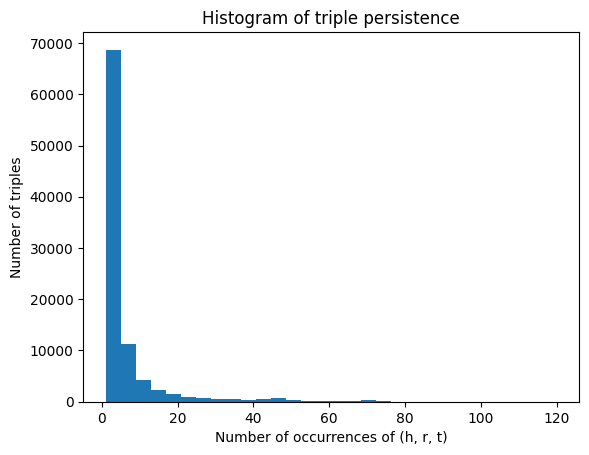

In [16]:
import matplotlib.pyplot as plt

plt.hist(rep.values, bins=30)
plt.xlabel("Number of occurrences of (h, r, t)")
plt.ylabel("Number of triples")
plt.title("Histogram of triple persistence")
plt.show()

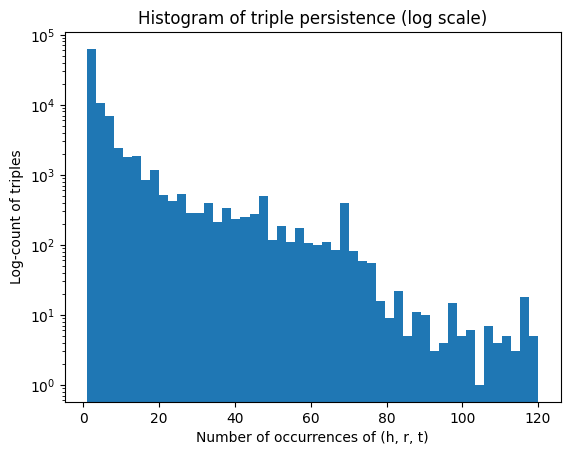

In [17]:
plt.hist(rep.values, bins=50, log=True)
plt.xlabel("Number of occurrences of (h, r, t)")
plt.ylabel("Log-count of triples")
plt.title("Histogram of triple persistence (log scale)")
plt.show()


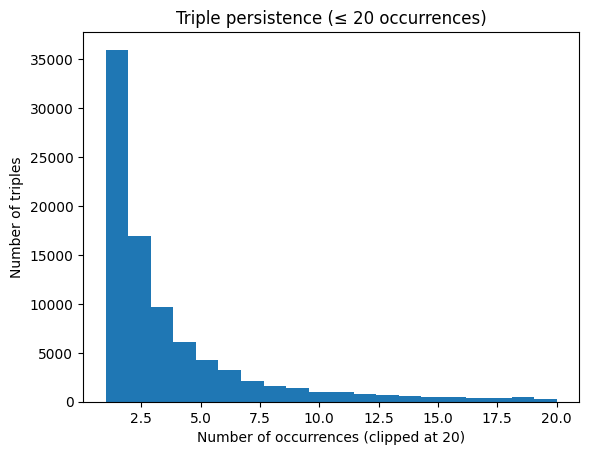

In [18]:
plt.hist(rep[rep <= 20], bins=20)
plt.xlabel("Number of occurrences (clipped at 20)")
plt.ylabel("Number of triples")
plt.title("Triple persistence (≤ 20 occurrences)")
plt.show()


In [19]:
import numpy as np

vals = rep.values

for k in [1, 2, 5, 10]:
    print(f"≤ {k} occurrences: {(vals <= k).mean():.2%}")

≤ 1 occurrences: 38.31%
≤ 2 occurrences: 56.32%
≤ 5 occurrences: 77.70%
≤ 10 occurrences: 87.60%


In [20]:
static = pd.read_csv("tkgl-smallpedia_static_edgelist.csv")

static["relation_type"].nunique()

753

In [21]:
df["relation_type"].nunique()

283

In [22]:
static["relation_type"].value_counts().head(10)

relation_type
P17      120924
P27       97583
P106      94363
P19       47512
P1412     46274
P421      30529
P20       29047
P641      25616
P69       23964
P131      22535
Name: count, dtype: int64

In [23]:
df["relation_type"].value_counts().head(10)

relation_type
P54      152605
P27       92758
P131      58327
P17       35313
P26       26480
P108      24443
P39       18241
P166      14011
P1411      8650
P463       7899
Name: count, dtype: int64

In [24]:
temp_unique = df.drop_duplicates(["head","relation_type","tail"])
stat_unique = static.drop_duplicates(["head","relation_type","tail"])

len(temp_unique), len(stat_unique)

(93953, 978022)

In [1]:
import pickle
with open("tkgl-smallpedia_test_ns.pkl","rb") as f:
    idx = pickle.load(f)

k = next(iter(idx.keys()))
print("example key:", k, type(k), len(k))
print("example val:", idx[k], type(idx[k]), idx[k].shape)


/var/folders/y3/yq4_6mjd0vxdjk2jv9k082q00000gn/T/ipykernel_82135/2381581240.py:3: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  idx = pickle.load(f)


example key: (np.int64(2008), np.int64(20583), np.int64(0)) <class 'tuple'> 3
example val: [24545] <class 'numpy.ndarray'> (1,)


In [2]:
with open("tkgl-smallpedia_val_ns.pkl","rb") as f:
    index = pickle.load(f)

test_start = int(min(k[0] for k in index.keys()))
test_end   = int(max(k[0] for k in index.keys()))
test_start, test_end

/var/folders/y3/yq4_6mjd0vxdjk2jv9k082q00000gn/T/ipykernel_82135/112576291.py:2: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  index = pickle.load(f)


(1998, 2007)